In [1]:
from rich.console import Console
from rich.syntax import Syntax
from rich.table import Table

def view(item):
    console = Console()
    with console.pager(styles=True):
        console.print(item)

## Specification Formulation

After entering the following, press [Run All Cells (Ctrl + F9)].

In [2]:
# @markdown ## Required Fields
# @markdown ### Content of the Textbook
book_content = "A textbook on linear algebra related to machine learning" #@param {type:"string"}
# @markdown ### Approximate Number of Pages
n_pages = 20 # @param {"type":"integer","placeholder":"40"}
# @markdown ### Output Format
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = True #@param {type:"boolean"}

# @markdown ## Optional Fields
# @markdown ### Intended Audience
target_readers = "A fourth-year university student who is already familiar with Python and Numpy and has started research on machine learning this year." #@param {type:"string"}
# @markdown ### Frequency of Equations
equation_frequency_level = 2 #@param {type:"slider", min:1, max:5, step:1}
# @markdown ### Consider Chapter Structure and Organization in Content Generation
do_consider_outline = True #@param {type:"boolean"}
# @markdown ### Consider Previous Output in Content Generation
do_consider_previous_sections = True #@param {type:"boolean"}
# @markdown ### Additional Requirements for Content
additional_requirements = "Try to explain the concept based on factual data." #@param {type:"string"}

if book_content == "":
    print('\033[31m'+'Please specify the content of the textbook.'+'\033[0m')
if n_pages == 0:
    print('\033[31m'+'Please specify the number of pages.'+'\033[0m')

## Prompt Definition

In [ ]:
# Common Prompt
prompt_common = f"""
The following content will be used to write a book.
{book_content}
The total number of pages in the book is {n_pages}, with an estimated 20 lines per page. Please write in a polite tone.
"""
if target_readers != "":
    prompt_common += f"The intended readers are as follows:\n {target_readers}"
if additional_requirements != "":
    prompt_common += f"Additionally, please take the following into consideration:\n {additional_requirements}"

# Prompt for Generating Book and Chapter Titles and Summaries
prompt_book_title = prompt_common + """
Based on the above, please provide the title and summary for the book and each chapter in the following JSON format.
The book summary should not only provide an overview but also mention the primary objectives, scope, and depth of the content, in about 5-10 detailed sentences.
Please also consider the page allocation for each chapter in units of 0.1, like 0.8 pages.
Additionally, consider whether each chapter needs further division based on semantic cohesion (needsSubdivision), and answer true or false.
Do not include any speculative or unverified information. Please avoid writing chapter numbers in the titles.
The number of sections should vary as needed. 
Please do not include any extra introductory or conclusory message outside the expected json format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
{{
"title": "",
"summary": "",
"childs":
    [
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
        {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
    ]
}}
```
"""

# Prompt for Section Division
prompt_section_list_creation = prompt_common + """
Based on the above information, I plan to create a book titled {book_title}. The book summary is as follows:
{book_summary}
For the section on {target}, I would like to create content across {n_pages} pages, assuming 40 lines per page.
The summary for this section is as follows:
{section_summary}
Please divide this section into multiple parts and output the titles and summaries of each part in the following JSON format.
Also, consider the page allocation for each part in units of 0.1, like 0.8 pages.
Additionally, consider whether each part needs further division based on semantic cohesion (needsSubdivision) and answer true or false.
Please avoid including section numbers in the titles. 
Please do not include any extra introductory or conclusory message outside the expected format.
Enclose the json content between ```json and ``` delimiters.

The output format should be strictly as follows:

```json
[
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }},
    {{"title": "", "summary": "", "n_pages": , "needsSubdivision": }}
]
```
"""

# Prompt for Generating Main Content
prompt_content_creation = prompt_common + """
Based on the above, I would like to create a book titled {book_title}. The book summary is as follows:
{book_summary}

I would like to create content for the section on {target}, across {n_pages} pages, assuming 20 lines per page. 
The summary for this section is as follows:
{section_summary}

{toc_and_summary}
{previous_sections}

Please output the content in the following format:
- Enclose the LaTeX content between <|tex_start|> and <|tex_end|> delimiters.
- Do not include speculative or unverified information.
- Only output the main content without headings.
- Do not include any extra introductory or conclusory message outside the expected format.
- For equations, use the `equation` or `align` environment; do not use nested environments.
- Escape special characters such as # as \\#.
- Please use ``` or backtick sequences within the generated LaTeX content where applicable. For example ```pyhon and ```.
- <|tex_start|> and <|tex_end|> delimiters should be used single time at the begining and at the end of the whole tex code.

The output must strictly begin with <|tex_start|> and end with <|tex_end|> delimiters as shown below:
    <|tex_start|>
    The tex content in the tex response
    <|tex_end|>
"""

## Parameter Settings

In [4]:
# Parameters
max_depth = 3  # If 1, only sections; if 2, includes subsections, and so on.
max_output_pages = 1.5  # Maximum number of pages output by the LLM

book_node_name = "book"  # Name of the root node

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

## Library Installation and Import

In [5]:
#!apt-get update
#!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#!apt-get install -y latexmk
#!apt-get install -y texlive-latex-extra
#!apt-get install -y texlive-science
#%pip install -qU langchain-openai
#%pip install pygraphviz
#%pip install pylatex

import os
import re
import json
import networkx as nx
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape


## Graph Creation

In [6]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

In [7]:
view(book_graph.graph)

{
    'book_content': 'A textbook on linear algebra related to machine learning',
    'target_readers': 'A fourth-year university student who is already familiar with Python and Numpy and has 
started research on machine learning this year.',
    'equation_frequency_level': 2,
    'additional_requirements': 'Try to explain the concept based on factual data.'
}


## Title and Chapter Creation

### Function Definition

In [8]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Function that extracts the first JSON data found in Markdown text
    and converts it to a Python dictionary.

    Args:
        markdown_text (str): A string in Markdown format, assumed to contain
        JSON-formatted data within it.

    Returns:
        dict or None: Returns a dictionary if a valid JSON is found;
        returns None if no JSON is found or parsing fails.
    """

    # Find the starting point of JSON in the Markdown
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # Traverse the entire string and check the balance of nested braces
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # Extract when braces are balanced
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # Convert to JSON format
                json_data = json.loads(json_string)
                view(json_data)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON parsing error: {e}")
                return None
            return

    # If no closing brace is found
    return None

### Output by LLM

In [9]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate

llm = OllamaLLM(base_url='http://localhost:11434', model="llama3.2:latest")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
   }
)

book_json = extract_book_and_chapter_contents(result)

{
    'title': 'Linear Algebra for Machine Learning',
    'summary': 'This textbook aims to bridge the gap between linear algebra and machine learning. The primary 
objective is to provide a comprehensive understanding of linear algebra concepts relevant to machine learning, 
focusing on mathematical foundations rather than computational implementations. The scope covers essential topics 
such as vector spaces, linear transformations, eigenvalues, eigenvectors, singular value decomposition, and matrix 
factorizations. The content assumes a strong foundation in Python programming and Numpy, with an emphasis on 
theoretical understanding. By the end of this textbook, students will be able to apply linear algebra concepts to 
real-world machine learning problems. The book is designed for fourth-year university students starting research in
machine learning. With 20 pages allocated per chapter, we aim to provide a balanced mix of theory and examples to 
facilitate deep understanding. This 

### Storing Results in the Book Graph

In [10]:
# About the book
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# About chapters (sections)
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## Title and Structure Verification

### Displaying Title and Structure

In [11]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## Title: " + book_node["title"] + " (Page Count: " + str(book_node["n_pages"]) + ")"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### Chapter " + str(idx+1) + ": " + child_node["title"] + " (Page Count: " + str(child_node["n_pages"]) + ")"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)



 ## Title: Linear Algebra for Machine Learning (Page Count: 20)
 This textbook aims to bridge the gap between linear algebra and machine learning. The primary objective is to provide a comprehensive understanding of linear algebra concepts relevant to machine learning, focusing on mathematical foundations rather than computational implementations. The scope covers essential topics such as vector spaces, linear transformations, eigenvalues, eigenvectors, singular value decomposition, and matrix factorizations. The content assumes a strong foundation in Python programming and Numpy, with an emphasis on theoretical understanding. By the end of this textbook, students will be able to apply linear algebra concepts to real-world machine learning problems. The book is designed for fourth-year university students starting research in machine learning. With 20 pages allocated per chapter, we aim to provide a balanced mix of theory and examples to facilitate deep understanding. This approach allows for both breadth and depth, covering essential topics in detail while also providing space for exploration and discussion.
 ### Chapter 1: Vector Spaces (Page Count: 0.8)
This chapter introduces vector spaces, including definitions, properties, and basic operations. It covers concept of dimensionality, basis, linear independence, span, and basis for subspaces.
 ### Chapter 2: Linear Transformations (Page Count: 1.2)
This chapter explores linear transformations, including properties such as linearity, invertibility, and matrix representations. It discusses eigenvalues, eigenvectors, and their applications.
 ### Chapter 3: Eigenvalue Decomposition (Page Count: 1.5)
This chapter focuses on singular value decomposition (SVD) as a fundamental tool for linear algebra in machine learning. It covers the algorithm, its properties, and applications.
 ### Chapter 4: Matrix Factorizations (Page Count: 1.8)
This chapter delves into various matrix factorizations such as QR, LU, Cholesky, and their relevance to machine learning. It covers algorithms, properties, and applications.
 ### Chapter 5: Advanced Topics (Page Count: 1.2)
This chapter explores more advanced topics such as pseudoinverses, determinant, and inverse of matrices. It provides deeper insights into linear algebra concepts relevant to machine learning.

## Book Graph Creation

### Function Definition

In [20]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON data not found.")
        return None

def extract_section_content(markdown_text):
    pattern = r'<\|tex_start\|>\s*(.*?)\s*<\|tex_end\|>'  # Regex to match custom delimiters
    match = re.search(pattern, markdown_text, re.DOTALL)  # Search across lines (re.DOTALL)
    if match:
        tex_string = match.group(1)  # Extract content between the delimiters
        return tex_string
    else:
        print("TeX data not found.")  # Handle cases with missing delimiters
        return markdown_text


def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "Avoid using equations whenever possible, and explain all concepts in simple words. Use equations only when absolutely necessary and keep it to a minimum."
    elif equation_frequency_level == 2:
        return "Use equations sparingly, focusing primarily on explanations in prose. Use simple equations only if necessary."
    elif equation_frequency_level == 3:
        return "Combine equations and prose explanations in a balanced way. Use equations to illustrate key concepts, supplementing with prose where needed."
    elif equation_frequency_level == 4:
        return "Use equations actively to precisely convey concepts and relationships. However, important explanations should also be supplemented with prose."
    elif equation_frequency_level == 5:
        return "Use equations extensively. Express as many concepts and relationships as possible through equations."

### LLMによる章立ての出力

In [13]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]

            view(child_node)

            if (child_node["needsSubdivision"] or child_node["n_pages"] >= max_output_pages) and depth < max_depth-1:

                # Output by LLM
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # Convert output to dictionary format
                section_json = extract_section_list(result)
                view(section_json)

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                # Only set as the next parent if subdivided
                next_parent_list.append(child_node_name)

            elif depth == (max_depth-1) or (child_node and not child_node["needsSubdivision"]):

                # Create graph nodes and store results
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

{
    'title': 'Vector Spaces',
    'summary': 'This chapter introduces vector spaces, including definitions, properties, and basic operations. It 
covers concept of dimensionality, basis, linear independence, span, and basis for subspaces.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Linear Transformations',
    'summary': 'This chapter explores linear transformations, including properties such as linearity, 
invertibility, and matrix representations. It discusses eigenvalues, eigenvectors, and their applications.',
    'n_pages': 1.2,
    'needsSubdivision': False
}


{
    'title': 'Eigenvalue Decomposition',
    'summary': 'This chapter focuses on singular value decomposition (SVD) as a fundamental tool for linear algebra
in machine learning. It covers the algorithm, its properties, and applications.',
    'n_pages': 1.5,
    'needsSubdivision': False
}


[
    {
        'title': 'Introduction to Singular Value Decomposition (SVD)',
        'summary': 'This section provides an introduction to SVD as a fundamental tool in linear algebra and 
machine learning. It covers the definition, properties, and applications of SVD.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Algorithm for Singular Value Decomposition (SVD)',
        'summary': 'This part explains the algorithm for computing SVD, including the QR decomposition and Jacobi 
method. It also discusses numerical stability and convergence issues.',
        'n_pages': 0.3,
        'needsSubdivision': False
    },
    {
        'title': 'Properties of Singular Value Decomposition (SVD)',
        'summary': 'This section covers the properties of SVD, including orthogonality, rank-defectiveness, and the
relationship between SVD and eigenvalue decomposition. It also discusses the implications of these properties for 
machine learning applications.

{
    'title': 'Matrix Factorizations',
    'summary': 'This chapter delves into various matrix factorizations such as QR, LU, Cholesky, and their 
relevance to machine learning. It covers algorithms, properties, and applications.',
    'n_pages': 1.8,
    'needsSubdivision': False
}


[
    {
        'title': 'Introduction to QR Decomposition',
        'summary': 'QR decomposition is a factorization method that decomposes a matrix A into the product of an 
orthogonal matrix Q and an upper triangular matrix R. This chapter covers the basics of QR decomposition, its 
algorithms, properties, and applications in machine learning.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'QR Decomposition Algorithms',
        'summary': 'This section discusses various algorithms for computing QR decomposition, including the 
Gram-Schmidt process and Householder transformations. It also covers the convergence of these algorithms and their 
computational complexities.',
        'n_pages': 0.8,
        'needsSubdivision': False
    },
    {
        'title': 'Properties of QR Decomposition',
        'summary': 'This part explores the properties of QR decomposition, including the uniqueness of Q and R, the
rank of A, and the relationships betwe

{
    'title': 'Advanced Topics',
    'summary': 'This chapter explores more advanced topics such as pseudoinverses, determinant, and inverse of 
matrices. It provides deeper insights into linear algebra concepts relevant to machine learning.',
    'n_pages': 1.2,
    'needsSubdivision': False
}


{
    'title': 'Introduction to Singular Value Decomposition (SVD)',
    'summary': 'This section provides an introduction to SVD as a fundamental tool in linear algebra and machine 
learning. It covers the definition, properties, and applications of SVD.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Algorithm for Singular Value Decomposition (SVD)',
    'summary': 'This part explains the algorithm for computing SVD, including the QR decomposition and Jacobi 
method. It also discusses numerical stability and convergence issues.',
    'n_pages': 0.3,
    'needsSubdivision': False
}


{
    'title': 'Properties of Singular Value Decomposition (SVD)',
    'summary': 'This section covers the properties of SVD, including orthogonality, rank-defectiveness, and the 
relationship between SVD and eigenvalue decomposition. It also discusses the implications of these properties for 
machine learning applications.',
    'n_pages': 0.3,
    'needsSubdivision': False
}


{
    'title': 'Applications of Singular Value Decomposition (SVD) in Machine Learning',
    'summary': 'This part explores the applications of SVD in machine learning, including dimensionality reduction,
feature extraction, and regularized regression. It also discusses the trade-offs between different techniques.',
    'n_pages': 0.4,
    'needsSubdivision': False
}


{
    'title': 'Case Studies: Using SVD for Real-World Applications',
    'summary': 'This section presents real-world case studies that demonstrate the application of SVD in machine 
learning, including image compression, recommendation systems, and more.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'Introduction to QR Decomposition',
    'summary': 'QR decomposition is a factorization method that decomposes a matrix A into the product of an 
orthogonal matrix Q and an upper triangular matrix R. This chapter covers the basics of QR decomposition, its 
algorithms, properties, and applications in machine learning.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'QR Decomposition Algorithms',
    'summary': 'This section discusses various algorithms for computing QR decomposition, including the 
Gram-Schmidt process and Householder transformations. It also covers the convergence of these algorithms and their 
computational complexities.',
    'n_pages': 0.8,
    'needsSubdivision': False
}


{
    'title': 'Properties of QR Decomposition',
    'summary': 'This part explores the properties of QR decomposition, including the uniqueness of Q and R, the 
rank of A, and the relationships between Q, R, and the transpose of A. It also discusses the applications of QR 
decomposition in machine learning.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


{
    'title': 'QR Decomposition in Machine Learning',
    'summary': 'This section highlights the role of QR decomposition in various machine learning algorithms, 
including singular value decomposition (SVD), principal component analysis (PCA), and least squares regression. It 
also discusses the advantages and limitations of using QR decomposition in machine learning.',
    'n_pages': 0.2,
    'needsSubdivision': False
}


### 本文の内容の出力

#### 関数定義

In [17]:
def extract_content_list(string_list):
    """
    This function extracts only the strings that match a specific pattern
    (a combination of numbers and hyphens ending in '-p') from the input string_list
    and returns them as a new list.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    This function splits the string s by the numerical parts,
    converting them into a list of integers,
    thereby generating a custom key for numerical sorting.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    This function sorts the input string_list using the custom key
    defined by the custom_sort_key function and returns the sorted list.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    This function extracts the leaf nodes of book_graph based on a specific pattern
    and returns a list sorted in numerical order.

    Arguments:
    - book_graph: A graph object with nodes labeled by strings

    Returns:
    - sorted_content_str_list: A sorted list of strings
    """
    # Extract strings matching a specific pattern from the nodes of book_graph
    content_str_list = extract_content_list(list(book_graph.nodes))

    # Sort the extracted list of strings using a custom key
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    A function to output the chapter structure to be considered for the main text output.
    """

    toc_and_summary = "The chapter structure is shown below.\n"

    # Sort the leaf nodes with content in order
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # Create the table of contents
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # Chapter
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Section
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # Subsection
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, content, original_list):
    # Create a shifted list, adding a new element (a dictionary with title and content) at the 0th position
    slid_list = [{"title": title, "content": content}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections):
    """
    This function generates a prompt based on previous sections.
    """
    prompt = ""

    for i in range(n_previous_sections):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        content = i_previous_section["content"]
        prompt += f"The title of part {i+1} sections ago is {title}, and the content is as follows.\n{content}\n"

    return prompt

#### 本文出力

In [21]:
# Output of chapter structure to consider when generating content
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# Initialize a list of strings to store previous outputs
previous_sections_content_list = [{"title": "", "content": ""} for i in range(n_previous_sections)]

# Sort the nodes containing the main content (leaf nodes) in order
sorted_content_str_list = sort_leaf_nodes(book_graph)

# Append the main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # Generate output via LLM
    
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"],
        }
    )

    view(result)
    contents_tex = extract_section_content(result)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # Retain past outputs
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], contents_tex, previous_sections_content_list)

<|tex_start|>

\section{Vector Spaces}

\label{sec:vector-spaces}
\begin{equation}
\mathbf{x} \in \mathbb{R}^n
\end{equation}
defines a vector space $\mathbb{R}^n$ as the set of all possible linear combinations of $n$ linearly independent 
vectors.

The dimensionality of a vector space is defined as the number of linearly independent basis vectors required to 
span the entire space. A basis for a vector space is a set of linearly independent vectors that spans the entire 
space.

\label{def:span}
Given a subset $S \subseteq \mathbb{R}^n$, the span of $S$ is defined as:

$$
\text{Span}(S) = \left\{
\sum_{i=1}^{k} c_i \mathbf{x}_i \mid c_i \in \mathbb{R}, k \leq n
\right\}
$$

where $\mathbf{x}_i$ are linearly independent vectors in $S$.

A subspace of a vector space is defined as a subset that satisfies the following properties:

1. The zero vector belongs to the subspace.
2. The subspace is closed under addition.
3. The subspace is closed under scalar multiplication.

\label{def:subspa

Here is the content for the section on Linear Transformations, across 1.2 pages, assuming 20 lines per page.

<|tex_start|>
\section{Linear Transformations}

A linear transformation $T: \mathbb{R}^n \to \mathbb{R}^m$ is a function that satisfies the following two 
properties:
- Linearity: $T(a \mathbf{x}) = a T(\mathbf{x})$ for all $\mathbf{x}$ and all scalars $a$
- Invertibility: $T$ has an inverse transformation $T^{-1}: \mathbb{R}^m \to \mathbb{R}^n$

The matrix representation of $T$ is given by:
$$
[T]_{\mathcal{B}} = [T(\mathbf{e}_i)]_{i=1}^{n}
$$

where $\mathcal{B}$ is a basis for $\mathbb{R}^m$. The transformation $T$ can also be represented as:
$$
[T \mathbf{x}]_{\mathcal{B}} = _{i=1}^{n}
$$

for some scalars $c_i$. In this case, the matrix representation is given by:
$$
[T]_{\mathcal{B}} = [T(\mathbf{e}_i)]_{i=1}^{n}
$$
</|tex_end|>


TeX data not found.
<|tex_start|>
\section{Linear Transformations}

A linear transformation $T: \mathbb{R}^n \to \mathbb{R}^m$ is a function that satisfies the following two 
properties:
- Linearity: $T(a \mathbf{x}) = a T(\mathbf{x})$ for all $\mathbf{x}$ and all scalars $a$
- Invertibility: $T$ has an inverse transformation $T^{-1}: \mathbb{R}^m \to \mathbb{R}^n$

The matrix representation of $T$ is given by:
$$
[T]_{\mathcal{B}} = [T(\mathbf{e}_i)]_{i=1}^{n}
$$

where $\mathcal{B}$ is a basis for $\mathbb{R}^m$. The transformation $T$ can also be represented as:
$$
[T \mathbf{x}]_{\mathcal{B}} = _{i=1}^{n}
$$

for some scalars $c_i$. In this case, the matrix representation is given by:

$$
[T]_{\mathcal{B}} = [T(\mathbf{e}_i)]_{i=1}^{n}
$$

A linear transformation can be represented as a matrix equation:
$T \mathbf{x} = A \mathbf{x}$

where $A$ is the matrix representation of $T$. The inverse of $T$ can also be represented by the inverse of $A$.

The transformation $T$ can also be r

KeyboardInterrupt: 

In [22]:
result

'<|tex_start|>\n\\section{Linear Transformations}\n\nA linear transformation $T: \\mathbb{R}^n \\to \\mathbb{R}^m$ is a function that satisfies the following two properties:\n- Linearity: $T(a \\mathbf{x}) = a T(\\mathbf{x})$ for all $\\mathbf{x}$ and all scalars $a$\n- Invertibility: $T$ has an inverse transformation $T^{-1}: \\mathbb{R}^m \\to \\mathbb{R}^n$\n\nThe matrix representation of $T$ is given by:\n$$\n[T]_{\\mathcal{B}} = [T(\\mathbf{e}_i)]_{i=1}^{n}\n$$\n\nwhere $\\mathcal{B}$ is a basis for $\\mathbb{R}^m$. The transformation $T$ can also be represented as:\n$$\n[T \\mathbf{x}]_{\\mathcal{B}} = [c_i]_{i=1}^{n}\n$$\n\nfor some scalars $c_i$. In this case, the matrix representation is given by:\n\n$$\n[T]_{\\mathcal{B}} = [T(\\mathbf{e}_i)]_{i=1}^{n}\n$$\n\nA linear transformation can be represented as a matrix equation:\n$T \\mathbf{x} = A \\mathbf{x}$\n\nwhere $A$ is the matrix representation of $T$. The inverse of $T$ can also be represented by the inverse of $A$.\n\nThe

## 本グラフの表示

The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.
These nodes contain information such as the title and summary of each chapter or section.
Additionally, the end nodes marked in red circles hold information on the content of the text.


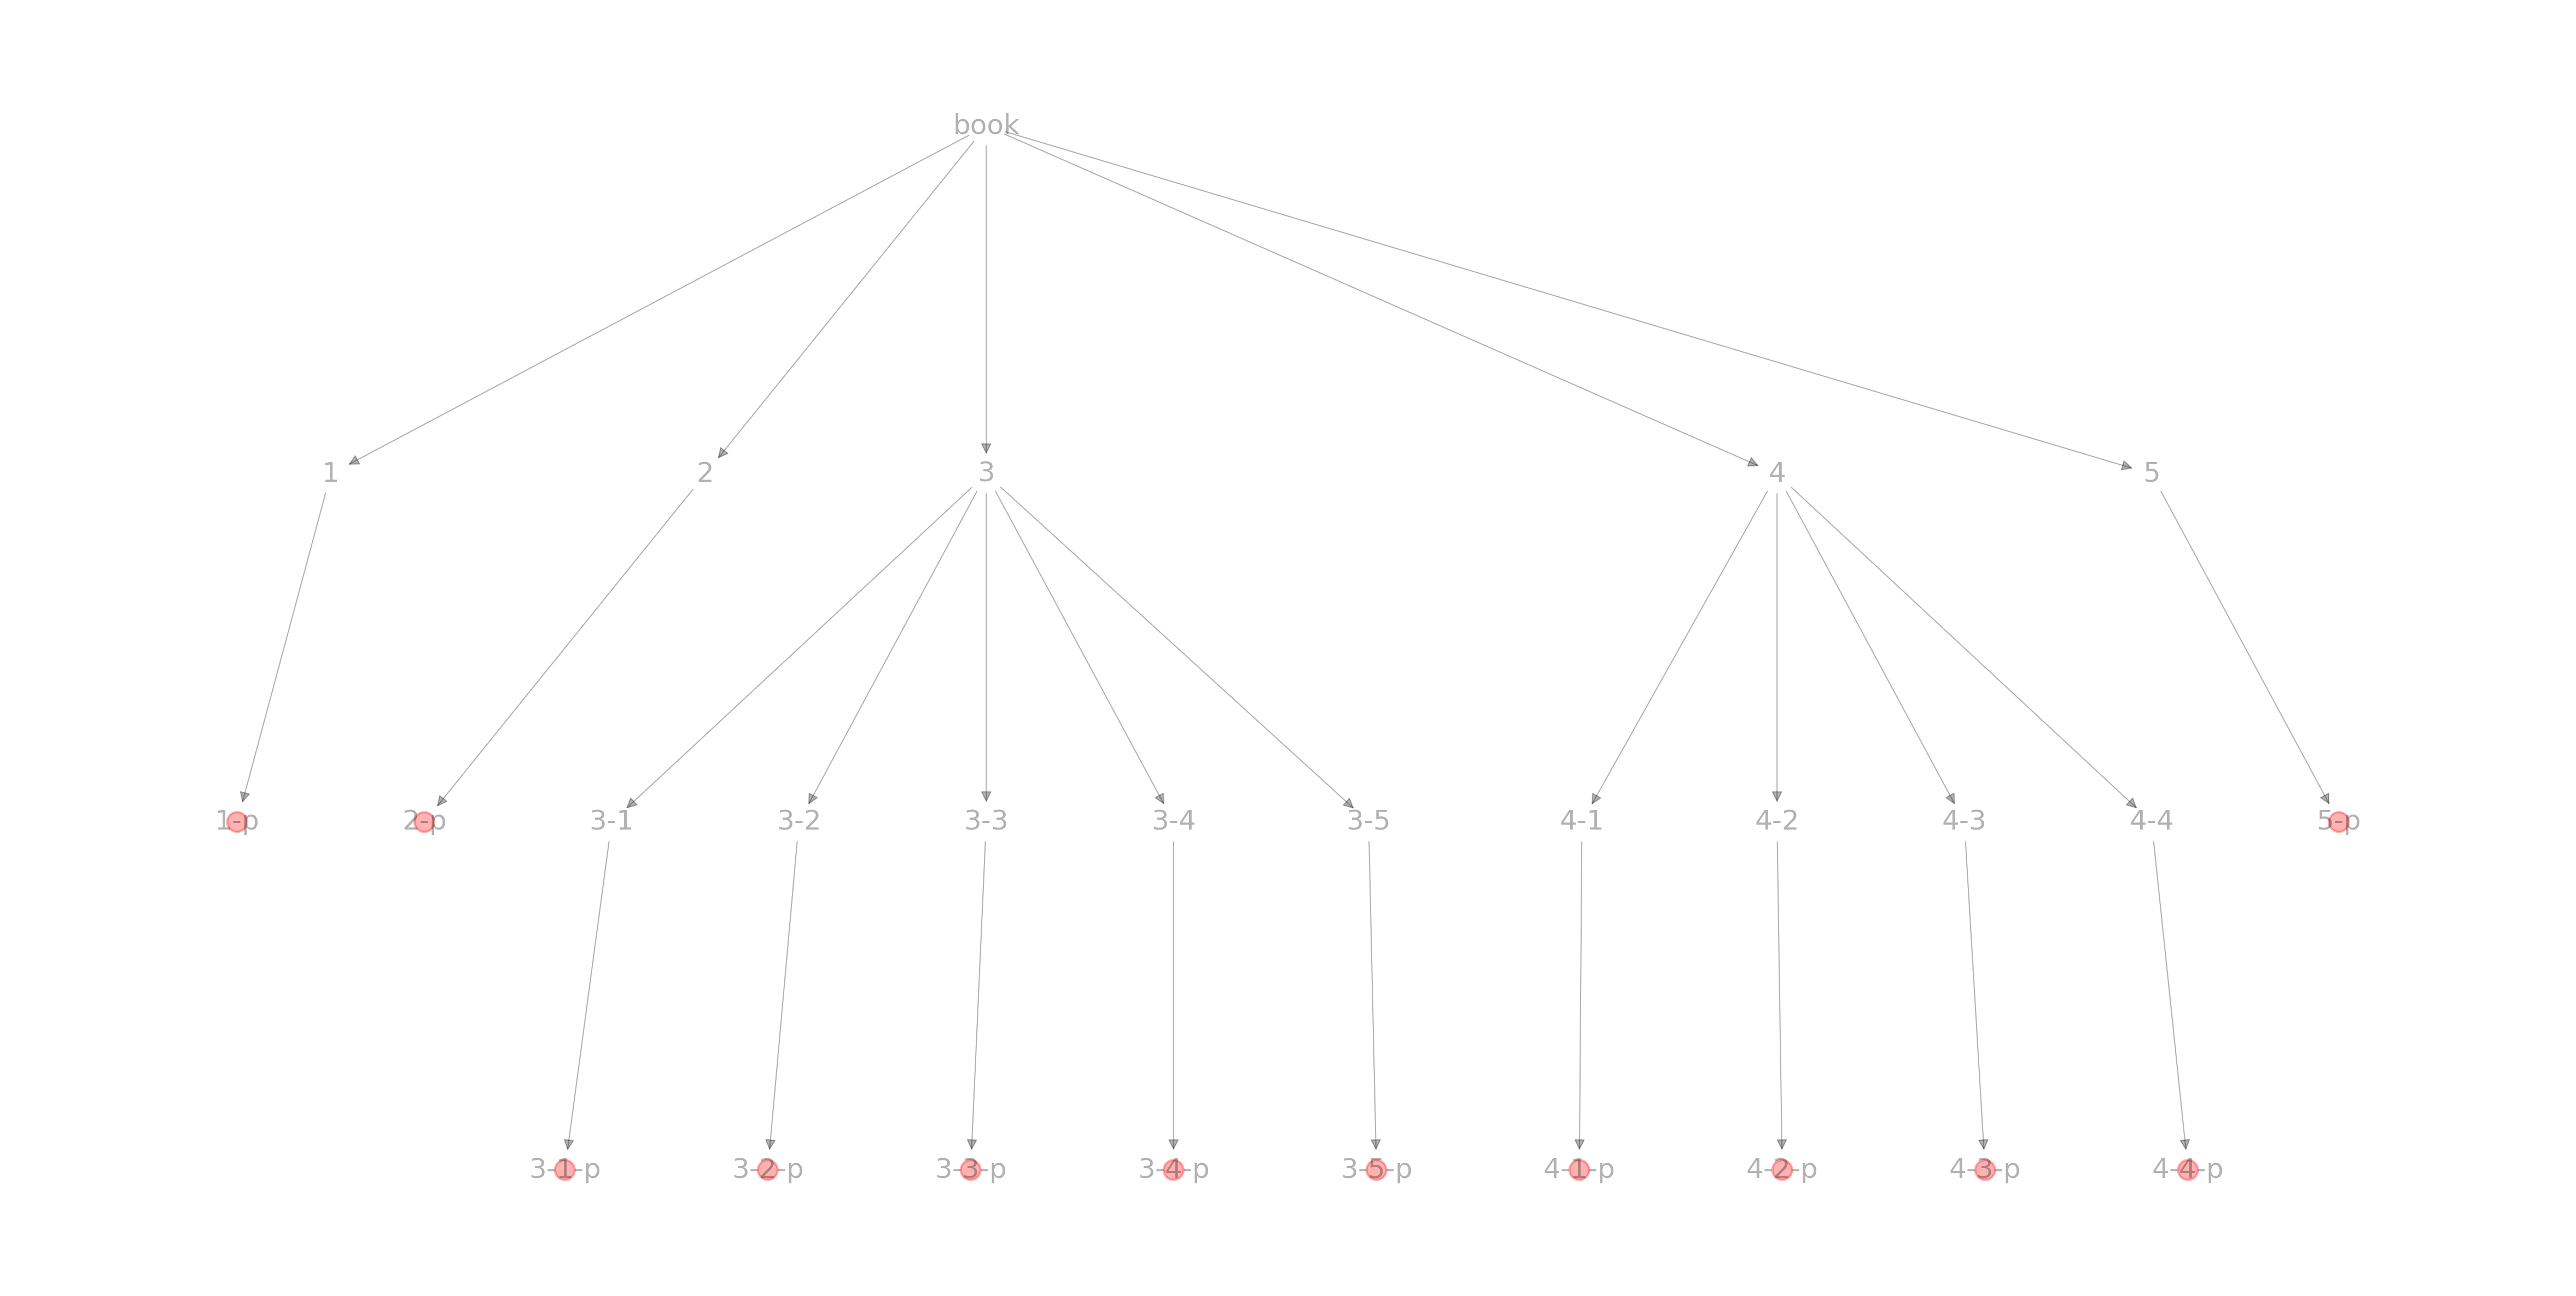

In [23]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# Color the leaf nodes (content nodes) in red
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("The arrows starting from 'book' represent chapters, with sections below them and subsections below the sections.\nThese nodes contain information such as the title and summary of each chapter or section.\nAdditionally, the end nodes marked in red circles hold information on the content of the text.")

## 本の作成

### latexmkrcファイルの作成

In [24]:
# Get the path of the home directory
home_dir = os.path.expanduser("~")

# Create the path for the .latexmkrc file
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# Contents of the latexmkrc file
content = '''$latex = 'pdflatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 1;'''

# Create the file and write the content
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc file has been created successfully at {latexmkrc_path}")
except IOError as e:
    print(f"An error occurred while creating the file: {e}")

.latexmkrc file has been created successfully at /Users/hissain/.latexmkrc


### LaTeXで本文の作成

### LaTeXドキュメントの作成

In [25]:
# Creating a PDF using pylatex
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# Adding preamble and title
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listings'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(Command("date", NoEscape(r"\today")))
doc.append(NoEscape(r"\maketitle"))
doc.append(NoEscape(r"\tableofcontents"))
doc.append(NoEscape(r'\lstset{ backgroundcolor={\color[gray]{.90}}, breaklines = true, breakindent = 10pt, basicstyle = \ttfamily\scriptsize, commentstyle = {\itshape \color[cmyk]{1,0.4,1,0}}, classoffset = 0, keywordstyle = {\bfseries \color[cmyk]{0,1,0,0}}, stringstyle = {\ttfamily \color[rgb]{0,0,1}}, frame = TBrl, framesep = 5pt, numbers = left, stepnumber = 1, numberstyle = \tiny, tabsize = 4, captionpos = t}'))

In [28]:
# Arrange nodes containing the main text content in order
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# Add main content
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # Add chapter title
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add section title
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add subsection title
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # Add main text content
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    try:
        with open(tex_file_path, "r", encoding='UTF-8') as file:
            tex_content = file.read()
            doc.append(NoEscape(tex_content))
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '4-4-p.tex'
[Errno 2] No such file or directory: '5-p.tex'


### PDFファイルの作成

In [29]:
# Compilation. A file named /content/textbook.pdf will be created
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
except:
    log_file_path = "/content/" + book_node["title"] + ".log"

    # Read the contents of the log file
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # Define error output pattern (file-line-error option format)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

if isErrorOccured:
    files.download("/content/" + book_node["title"] + ".tex")
    raise Exception("An error occurred while compiling the TeX file. Please run it again or refer to the error details above and try compiling after correcting the errors.")

### Markdownファイルの作成

In [30]:
def clean_markdown_content(content):
    # Remove the part before the first heading (LaTeX settings section)
    content = content.split('#', 1)[1]

    # Remove % only when it has whitespace before or after
    content = re.sub(r"(?<=\s)%|%(?=\s)", "", content)

    # Remove % only when it appears at the end of a line
    content = re.sub(r"%\s*$", "", content)

    # Replace multiple newlines with a single newline
    content = re.sub(r"\n{2,}", "\n\n", content)

    return content

def convert_to_latex_to_katex(content):
    # Convert align and align* environments
    content = re.sub(r'\\begin{align\*?}', r'$$\n\\begin{aligned}', content)
    content = re.sub(r'\\end{align\*?}', r'\\end{aligned}\n$$', content)

    # Convert equation and equation* environments
    content = re.sub(r'\\begin{equation\*?}', r'$$', content)
    content = re.sub(r'\\end{equation\*?}', r'$$', content)

    return content

def transform_code_blocks(content):

    # Extract and handle language option
    def replace_lstlisting(match):
        options = match.group(1)
        code = match.group(2)
        # Search for language option
        lang_match = re.search(r'language=([a-zA-Z]+)', options)
        lang = lang_match.group(1) if lang_match else ''
        # Convert to Markdown format
        return f'```{lang}\n{code}\n```'

    # Conversion process for lstlisting
    content = re.sub(r'\\begin{lstlisting}\[(.*?)\](.*?)\\end{lstlisting}', replace_lstlisting, content, flags=re.DOTALL)

    return content

In [33]:
# if md_output:
#     %pip install latex2markdown
#     import latex2markdown

#     with open(book_node["title"] + ".tex", "r") as f:
#         latex_string = f.read()

#     # Convert LaTeX to Markdown
#     processed_latex_str = transform_code_blocks(latex_string)
#     l2m = latex2markdown.LaTeX2Markdown(processed_latex_str)
#     markdown_string = l2m.to_markdown()

#     # Format the Markdown text
#     cleaned_md_str = clean_markdown_content(markdown_string)
#     katex_md_str = convert_to_latex_to_katex(cleaned_md_str)

#     with open(book_node["title"] + ".md", "w") as f:
#         f.write(katex_md_str)
#     files.download(book_node["title"] + ".md")